<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [41]:
import pandas as pd
import zipfile
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore


import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import spacy
from spacy.tokenizer import Tokenizer
from collections import Counter
import squarify
import warnings
import pyLDAvis.gensim

In [5]:
zf = zipfile.ZipFile('./data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv.zip') # having First.csv zipped file.
amazon_reviews = pd.read_csv(zf.open('Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'))
print(amazon_reviews.shape)
amazon_reviews.head()

In [8]:
nlp = spacy.load("en_core_web_lg")

In [13]:
def clean_soup(df_column, spec_chars_remove = []):
    
    """
    Input: dataframe column and list of specific characters to remove, 
    
    Output: List of cleaned observations
    """
    
    soupy = [BeautifulSoup(df_column[ii], 'lxml').get_text() 
             for ii in range(df_column.shape[0])]
    
    for char in spec_chars_remove:
        soupy = [soupy[ii].replace(char, ' ') for ii in range(len(soupy))]
        
    to_clean = ['[^A-Za-z0-9 ]+', '   ', '  ']
    
    for char in to_clean:
        soupy = [re.sub(char, ' ', soupy[ii]) for ii in range(len(soupy))]
        
    df_feature = pd.Series([nlp(soupy[ii].lower().strip()) for ii in range(len(soupy))])
        
    for row in range(df_feature.shape[0]):
        df_feature[row] = " ".join([token.lemma_ for token in df_feature[row]])
         
    return df_feature

In [14]:
amazon_reviews['reviews.text'] = clean_soup(amazon_reviews['reviews.text'])
amazon_reviews['reviews.text'].head(10)

0    i order 3 of -PRON- and one of the item be bad...
1    bulk be always the less expensive way to go fo...
2    well -PRON- be not duracell but for the price ...
3    seem to work as well as name brand battery at ...
4    these battery be very long last the price be g...
5    buy a lot of battery for christmas and the ama...
6    -PRON- have not have any problame with these b...
7    well if -PRON- be look for cheap non rechargea...
8    these do not hold the amount of high power jui...
9    amazonbasic aa aaa battery have do well by -PR...
Name: reviews.text, dtype: object

In [16]:
def make_tokens(df_feature, addl_stop_words = ['-PRON-']):
    """
    Input: Column of a dataframe/ Pandas Series, 
    stop words you'd like to add to nlp's defaults
    
    Output: List consisting of tokens for each observation
    
    Assumes: nlp object initialized as nlp
    """
    
    tokens = []
    tokenizer = Tokenizer(nlp.vocab)

    STOP_WORDS = nlp.Defaults.stop_words.union(addl_stop_words)

    for doc in tokenizer.pipe(df_feature, batch_size=500):

        doc_tokens = []

        for token in doc: 
            if token.text not in STOP_WORDS:
                doc_tokens.append(token.text.lower())

        tokens.append(doc_tokens)

    return tokens

In [27]:
stop_words = ['-PRON-', 't', 's', 'amazon', ]
amazon_reviews['review_tokens'] = make_tokens(amazon_reviews['reviews.text'], stop_words)
amazon_reviews['review_tokens'].head()

0    [order, 3, item, bad, quality, miss, backup, s...
1                [bulk, expensive, way, product, like]
2                             [duracell, price, happy]
3                        [work, brand, battery, price]
4                        [battery, long, price, great]
Name: review_tokens, dtype: object

In [18]:
def count(docs):
    """
    Input: Series of spacy docs objects / dataframe column
    
    Output: Pandas dataframe consisting of words and their 
    stats based on how many times they appear in the series
    """
    word_counts = Counter()
    appears_in = Counter()
       
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())
        
    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()

    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
    return wc.sort_values(by='rank')

In [28]:
wc = count(amazon_reviews['review_tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
7,battery,6694,10283,1.0,0.031740,0.031740,0.236270
21,great,8224,9512,2.0,0.029360,0.061100,0.290272
3458,tablet,5615,7411,3.0,0.022875,0.083975,0.198186
24,good,6271,7242,4.0,0.022354,0.106329,0.221340
86,use,5614,6925,5.0,0.021375,0.127704,0.198151


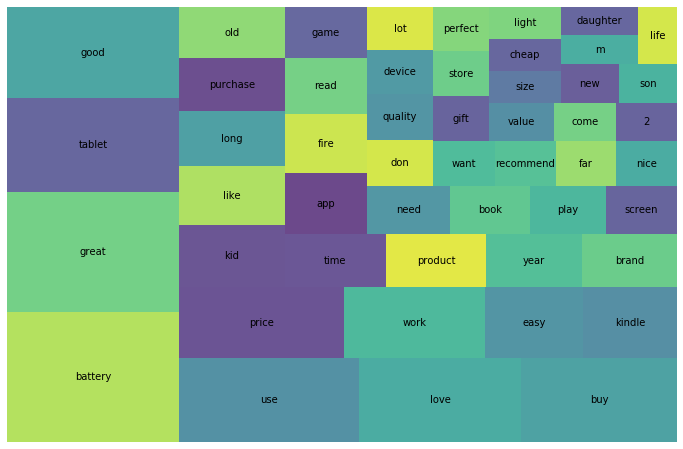

In [29]:
wc_top50 = wc[wc['rank'] <= 50] #explore what the top words are and help find additional stop_words

plt.rcParams['figure.figsize'] = (12,8)
squarify.plot(sizes=wc_top50['pct_total'], label=wc_top50['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [32]:
id2word = corpora.Dictionary(amazon_reviews['review_tokens'])
id2word.filter_extremes(no_below=5, no_above=0.95)

corpus = [id2word.doc2bow(text) for text in amazon_reviews['review_tokens']]

In [34]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [35]:
coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus,
                                                        start=2, 
                                                        limit=10,
                                                        step=2,
                                                        passes=40)

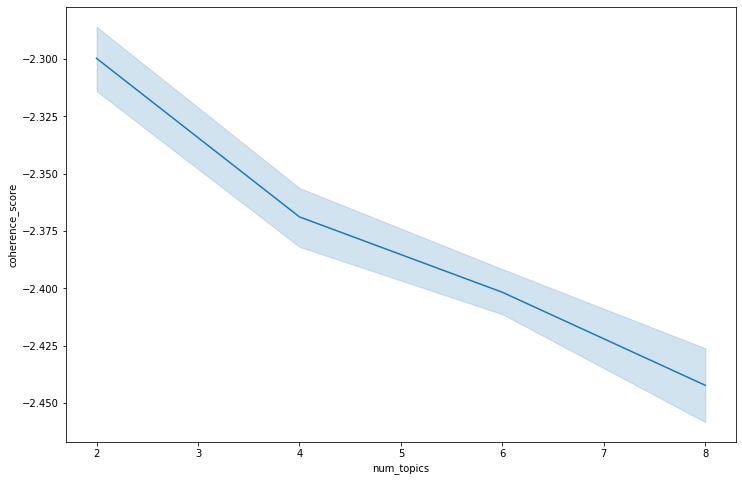

In [37]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)
plt.show()

In [39]:
warnings.filterwarnings("ignore",category=DeprecationWarning)


lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics =4,
                   passes=10,
                   workers=6
                  );

In [40]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

topics = [' '.join(t[0:5]) for t in words]

for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
read use kindle book tablet

------ Topic 1 ------
battery good long brand buy

------ Topic 2 ------
tablet love use kid old

------ Topic 3 ------
great price good work product



In [42]:
pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(lda, corpus, id2word)

/home/j_m/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.159365  0.087867       1        1  30.788639
1     -0.095473 -0.176194       2        1  27.589766
0      0.128716 -0.042985       3        1  27.230267
3     -0.192608  0.131312       4        1  14.391325, topic_info=    Category         Freq     Term        Total  loglift  logprob
20   Default  9409.000000    great  9409.000000  30.0000  30.0000
3    Default  9343.000000  battery  9343.000000  29.0000  29.0000
18   Default  5231.000000    price  5231.000000  28.0000  28.0000
30   Default  7346.000000     good  7346.000000  27.0000  27.0000
10   Default  4457.000000     work  4457.000000  26.0000  26.0000
..       ...          ...      ...          ...      ...      ...
39    Topic4   217.884766    cheap  1045.193115   0.3706  -5.3361
82    Topic4   332.226349      use  6805.458008  -1.0811  -4.9143
117   Topic4   218.162628     gift  1155.100952   0.2718  -5.3349
141   Topic4   236.082733     time  2393.493164  -0.3778  -5.2559
162   Topic4   234.245300      kid  2927.799561  -0.5871  -5.2637

[318 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
186       1  0.637887      2
186       2  0.312746      2
186       3  0.044814      2
186       4  0.004767      2
131       2  0.990860     48
...     ...       ...    ...
832       3  0.012222  young
832       4  0.040739  young
1509      1  0.980782     yr
1509      3  0.004359     yr
1509      4  0.017436     yr

[702 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling